# Capstone Project - Predicting Student Final Results

### Project Objective
This project aims to build a model that will confidently predict those students who are at risk of withdrawing or failing a particular subject. The data comes from the **Open University**, which is the biggest university in the UK for undergraduate degrees with currently almost 170 000 students.
Most students at Open University study off-campus and the virtual learning environment (VLE) provides the main connection between the student and the institution. Due to the lack of the traditional campus presence of students, there is a risk of disconnection between the two, which could lead to a lack of supports of students who might be struggling with the workload.

**This model could be used by the university to identify the students who need more support and prevent them from failing or withdrawing from the course.**


### About the Dataset
* The data contains information from the Open University Virtual Learning Environment(VLE) which off-campus students use for accessing the course content, forum discussions, sending assessments and checking out assignment marks.

* It consists of 7 selected courses (=modules) from 4 different semesters (=presentations).

* The dataset includes student demographics such as location, age group, disability, education level and gender.

## Notebook Contents
### 1) Obtaining data + Joining Tables
* studentInfo table
* looking at final results distribution
* studentVle table
* aggregating data and joining tables (studentInfo + studentVle)
* studentAssessment table
* joining the table with Assessments info (studentInfo + studentVle + studentAssessments)

### 2) Data Exploration
Exploring the relationships between the final outcome and the following:
* number of clicks in VLE
* average grade from assignments
* disability
* IMB score - deprivation index

### 3) Preparing Variables for Modelling
* creating dummy variables
* splitting data into training (85%), validation (10%) and test (5%) sets
* tackling class imbalance by SMOTE resampling


### 4) Building the Models
* Model 1 - Random Forest
* Model 2 - Random Forest with grid-search
* Model 3 - XGBoost
* Model 4 - LightGBM

### 5) Examining the Best Model and Conclusion
* final model testing
* main findings
* future work

# 1) Obtainting and cleaning data + joining tables

In [1]:
#importing essential libraries and a visualisation function

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import seaborn as sns


def plot_cat_var(column,title,size=(10,6)):
    new_d = dict(column.value_counts())
    d_keys = list(new_d.keys())
    d_values = list(new_d.values())

    plt.figure(figsize=size)
    plt.bar(d_keys, d_values,color='#1e9cbd', width=0.5)
    plt.title(title,fontsize=20)

### studentInfo table

In [2]:
#loading the studentInfo table
st = pd.read_csv('data/studentInfo.csv')
st.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [3]:
len(st.id_student.unique())

28785

In [4]:
st.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

**imd_band**
* The Index of Multiple Deprivation 2015 is the official measure of relative deprivation for small areas (or neighbourhoods) in England.
* The Index of Multiple Deprivation ranks every small area in England from 1 (most deprived area) to 32,844 (least deprived area).
* This variable shows to which band the student belongs to.

Due to some student repeating modules, for the initial demographic analysis I will remove their duplicate information and only keep one record per student.

In [5]:
#dropping multiple records from the dataset
st_clean = pd.DataFrame.drop_duplicates (st, subset = 'id_student')

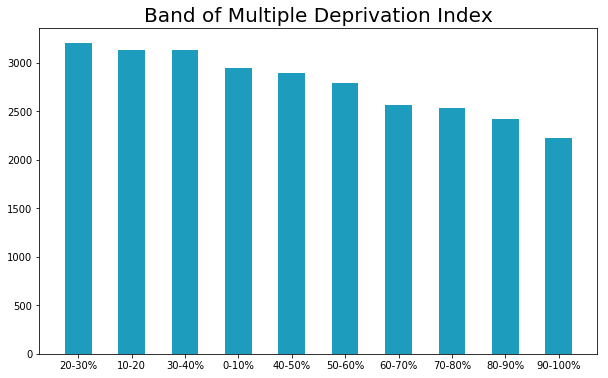

In [6]:
plot_cat_var(st_clean.imd_band,'Band of Multiple Deprivation Index')

There is not a prevailing value. I will therefore theat the missing values as its own category.


In [7]:
st.imd_band.fillna('Missing',inplace=True)

#### How many students passed, failed or withdrew?

Pass           0.376342
Withdrawn      0.314157
Fail           0.217613
Distinction    0.091888
Name: final_result, dtype: float64

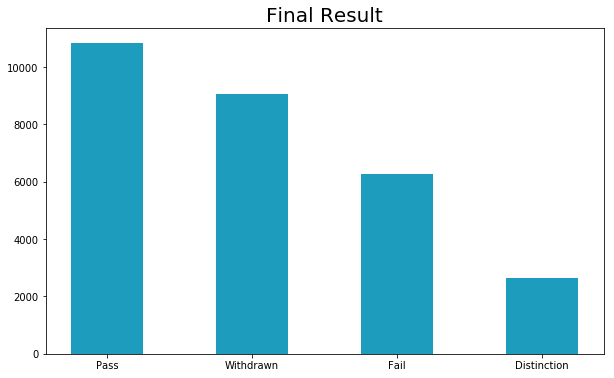

In [8]:
plot_cat_var(st_clean.final_result,'Final Result')
st_clean.final_result.value_counts(normalize=True)

**Final Results**
* 37% of students have finished their modules + 9% with a distinction
* 31% have withdrawn from a module
* 22% of students failed

My projected model's objective is to predict students who are likely to fail or withdraw from their module. Predicting whether a student will get a destiction is pointless for this task. For this reason, I will join students who pass with or without distinction into the same class 'Pass'.

In [9]:
#Joining 'Distinction' class with 'Pass'
st.loc[st['final_result'] == 'Distinction','final_result'] = 'Pass'

### Virtual Learning Environment Dataset (VLE)

- This table contains information about student's interactions with the virtual learning environment. 

- the materials provided in the VLE are mostly HTML pages and PDF files
- 'id_site' variable refers to the study material
- 'date' the date of the student's interaction with the material
- 'sum_click' - the number of times the student interacted with the material

In [10]:
vle = pd.read_csv('data/studentVle.csv')

In [11]:
vle.head()
#this datasetset has no missing values

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [12]:
print(len(vle.id_student.unique()))

26074


There are 26074 unique students have interacted with the VLE, but there are 28 785 unique students overall. It suggests that there might be 2711 students who have not used the VLE at all.

I will now find students who are not in the VLE table to investigate their results.

In [13]:
#let's find you which students are not in the VLE table
unique_vle_students = set(vle.id_student)
unique_total_students = set(st.id_student)

#this is a list of students who are not present in VLE df
students_not_in_vle = list(unique_total_students.difference(unique_vle_students))

#this is a dataframe with information about students who are not present in the VLE df
df_not_in_vle = st_clean[st_clean.id_student.isin(students_not_in_vle)]

Withdrawn    2385
Fail          323
Pass            3
Name: final_result, dtype: int64

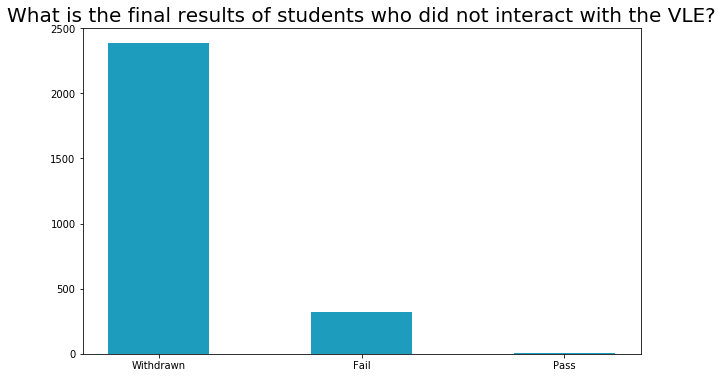

In [14]:
plot_cat_var(df_not_in_vle.final_result,'What is the final results of students who did not interact with the VLE?')
df_not_in_vle.final_result.value_counts(normalize=False)

The students who have not used the VLE at all have mostly withdrawn from the module or failed. This means that that having no VLE interactions might an big indicator of who will withdraw or fail the module.

It can also mean that these are the students who have changed their minds about the module and left without ever using the VLE. However, I do not have the information about the date of their withdrawal and cannot saperate them from the dataset.

Also, there is 12% of students who failed their module in this dataset.

#### Dates of student materials - too many missing values

In [15]:
activity = pd.read_csv('data/vle.csv')
activity.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [16]:
print(activity.week_from.isna().sum())
print(activity.week_to.isna().sum())
print(len(activity))

5243
5243
6364


Unfortunately, this table has too many values to determine the dates of VLE materials released.

### Joining Student and VLE datasets

I will create a dataset with information about students and their interactions in VLE.

This table will be module-oriented, rather than student oriented, because there are some students who have studied multiple modules that were chosen for this project.

Moreover, the model does not aim to predict the student's overall result, but the student's result in a particular module.

In [17]:
#This information won't be useful - dropping columns
vle_for_joining = vle.drop(['id_site','date'],axis =1)

In [18]:
#checking for missing values
vle_for_joining.isna().sum()

code_module          0
code_presentation    0
id_student           0
sum_click            0
dtype: int64

In [19]:
vle_for_joining.head()

,code_module,code_presentation,id_student,sum_click
0,AAA,2013J,28400,4
1,AAA,2013J,28400,1
2,AAA,2013J,28400,1
3,AAA,2013J,28400,11
4,AAA,2013J,28400,1


In [20]:
#Here I will sum all clicks/interactions from the VLE table per module studied
df_sum_click = vle_for_joining.groupby(['code_module', 'code_presentation','id_student']).agg({'sum_click': ['sum']})

In [21]:
df_sum_click.head()

sum_click
                                               sum
code_module code_presentation id_student          
AAA         2013J             11391            934
                              28400           1435
                              30268            281
                              31604           2158
                              32885           1034

In [22]:
#renaming the 'sum_click' column
df_sum_click.columns = ['sum_of_clicks']

In [23]:
#setting a new index
df_sum_click_new_index = df_sum_click.reset_index()

This is now the table with the sum of clicks each student did in the modules represented in the dataset.

In [24]:
df_sum_click_new_index.head()

,code_module,code_presentation,id_student,sum_of_clicks
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034


In [25]:
#merging the student dataset with the above dataset
st_actives_with_vle = pd.merge(st, df_sum_click_new_index,
                               on=['code_module','code_presentation','id_student'],
                               how='left')

# st_new_join = st.join(df_sum_click_new_index, how='left', on=['code_module','code_presentation','id_student'])


This dataframe now contains the total number of clicks per module and presentation, as well as demograhic information about the students.

In [26]:
st_actives_with_vle.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


In [27]:
#st_actives_with_vle.isna().sum()

In [28]:
#st_actives_with_vle.loc[st_actives_with_vle.sum_of_clicks.isna() == True]

In [29]:
#I will replace the NaN with 0 as they represent the students who have not interacted in the VLE
st_actives_with_vle.sum_of_clicks.fillna(0,inplace=True)

### Assessments table

In [30]:
#obtaining the studentAssessment table
df_a = pd.read_csv('data/studentAssessment.csv')

This table describes the grade each student received for each assessments.

In [31]:
df_a.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [32]:
df_a.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [33]:
df_a.dropna(inplace=True)

In [34]:
#obtaining the assessments table
df_as = pd.read_csv('data/assessments.csv')

This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam.

date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).

**I will remove all assessments that happen after 100 days in order to train the dataset on early assignments only.**

In [35]:
df_as.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


As we can see, the assessment most frequently happen towards the end of the presentation (=semester)

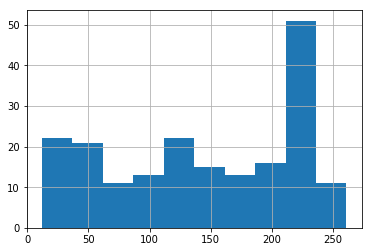

In [36]:
df_as.date.hist()

In [37]:
#removing all assessments that happened after 100 days
df_as = df_as[df_as.date < 100]

In [38]:
df_as.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
6,AAA,2014J,1758,TMA,19.0,10.0
7,AAA,2014J,1759,TMA,54.0,20.0
12,BBB,2013B,14991,CMA,54.0,1.0


In [39]:
len(df_as.id_assessment.unique())
#63 unique assessments left
list_of_early_assessments = list(df_as.id_assessment.unique())

In [40]:
#I will now clean the table with the student grades from the later assessments
early_assessments = df_a[df_a['id_assessment'].isin(list_of_early_assessments) == True]

#### What grades are students receiving in the early semester?

In [41]:
#Here I will calculate the average student grade from their assessments
df_average_grade = early_assessments.groupby(['id_student']).agg({'score': ['mean']})
len(early_assessments.id_student.unique()) #23248
len(df_average_grade) #23248 unique students with an average grade gained from table
df_average_grade.head()

,score
,mean
id_student,
6516,54.000000
8462,87.000000
11391,81.500000
23629,82.500000
23698,88.333333


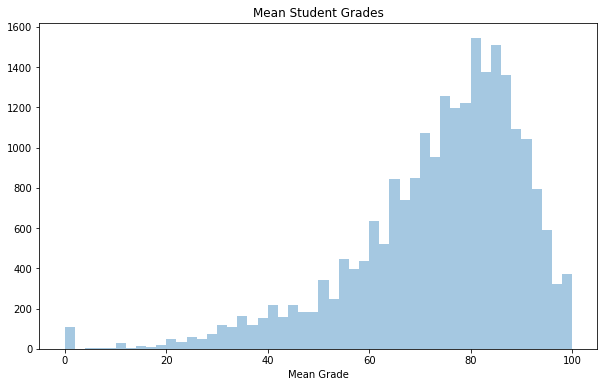

In [42]:
plt.figure(figsize=(10,6))
av_plot = sns.distplot(df_average_grade, kde=False)
av_plot.set_title('Mean Student Grades')
av_plot.set_xlabel('Mean Grade');

In [43]:
df_average_grade.describe()

,score
,mean
count,23248.000000
mean,73.634832
std,16.714053
min,0.000000
25%,65.333333
50%,77.000000
75%,85.400000
max,100.000000


The average student overall grade from all their assignments is 73 and the median is 79.

In [44]:
len(st_actives_with_vle.id_student.unique()) - len(df_average_grade)
#we have missing grade information for over 5000 students, who have not completed any assessments
#As this is a continuous variable, I will replace their grade with the median grade

5537

In [45]:
#renaming columns before setting a new index
df_average_grade.columns = ['mean_grade']

In [46]:
#setting a new index
df_average_grade.reset_index(inplace=True)

In [47]:
df_average_grade.head()

,id_student,mean_grade
0,6516,54.000000
1,8462,87.000000
2,11391,81.500000
3,23629,82.500000
4,23698,88.333333


In [48]:
#merging with main dataset
st_actives_with_vle = pd.merge(st_actives_with_vle, df_average_grade,
                               on=['id_student'],
                               how='left')

In [49]:
st_actives_with_vle['mean_grade'].fillna(st_actives_with_vle['mean_grade'].median(),inplace=True)
st_actives_with_vle.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
sum_of_clicks           0
mean_grade              0
dtype: int64

In [50]:
st_actives_with_vle.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks,mean_grade
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,81.5
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,69.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,77.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,71.5
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,49.5


# 2) EDA - Exploratory Data Analysis

#### Final result and average grade

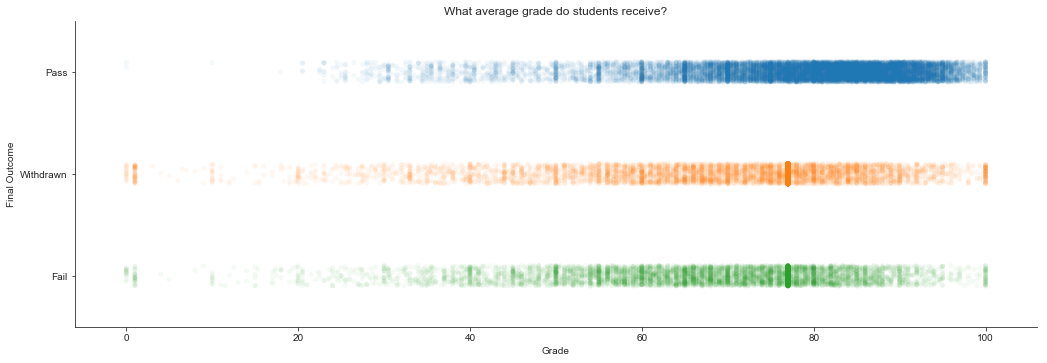

In [51]:
sns.set_style("ticks")
fig_1 = sns.catplot(y="final_result", x="mean_grade", data=st_actives_with_vle, alpha = 0.05)
fig_1.fig.set_figwidth(18)
fig_1.fig.set_figheight(5)
fig_1.set(xlabel='Grade', ylabel='Final Outcome',title='What average grade do students receive?');

As we can see above, the students who pass their modules receive higher grades than those who withdraw or fail. The grades of students who fail are concentrated lower than in the other categories. This confirms what was naturally expected.

#### Final result and the number of clicks

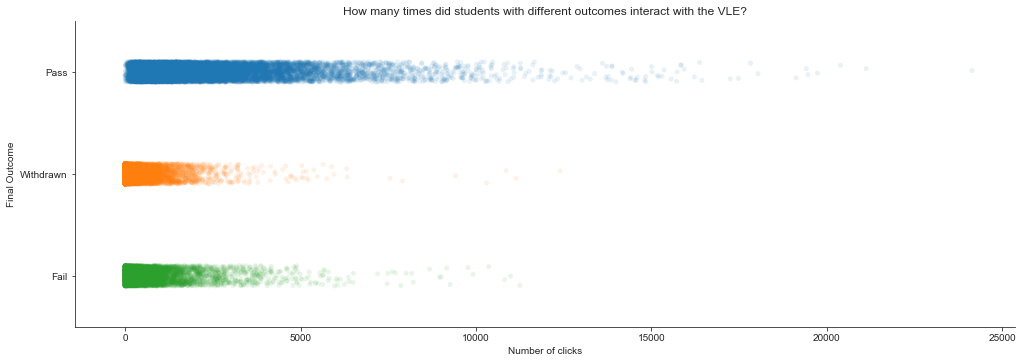

In [52]:
fig_2 = sns.catplot(y="final_result", x="sum_of_clicks", data=st_actives_with_vle, alpha = 0.1)
fig_2.fig.set_figwidth(18)
fig_2.fig.set_figheight(5)
fig_2.set(xlabel='Number of clicks', ylabel='Final Outcome',title='How many times did students with different outcomes interact with the VLE?');

In [53]:
st_actives_with_vle_no_outliers = st_actives_with_vle[st_actives_with_vle.sum_of_clicks < 5000]

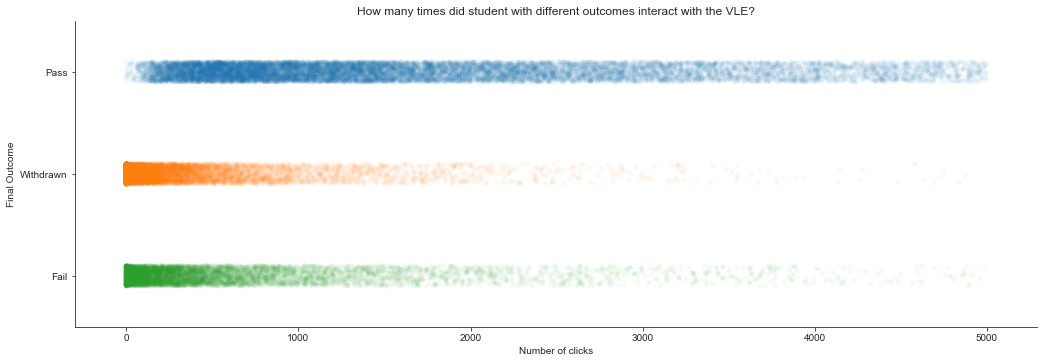

In [54]:
fig_3 = sns.catplot(y="final_result", x="sum_of_clicks", data=st_actives_with_vle_no_outliers, alpha = 0.05)
fig_3.fig.set_figwidth(18)
fig_3.fig.set_figheight(5)
fig_3.set(xlabel='Number of clicks', ylabel='Final Outcome',title='How many times did student with different outcomes interact with the VLE?');

In [55]:
failed = st_actives_with_vle.loc[st_actives_with_vle.final_result == 'Fail']
passed = st_actives_with_vle.loc[st_actives_with_vle.final_result == 'Pass']
withdrew = st_actives_with_vle.loc[st_actives_with_vle.final_result == 'Withdrawn']

#Average grades for the three categories
print('Average grades')
print('Passed: '+str(passed.mean_grade.mean()))
print('Withdrew: '+str(withdrew.mean_grade.mean()))
print('Failed: '+str(failed.mean_grade.mean()))

Average grades
Passed: 78.52199201495421
Withdrew: 71.67916539857018
Failed: 68.05864598194073


As we can see, the average grade naturally corresponds with the final results. The grade difference between 'Fail' and 'Withdrawn' is not too large.

#### What is the role of disability?

N    0.902924
Y    0.097076
Name: disability, dtype: float64

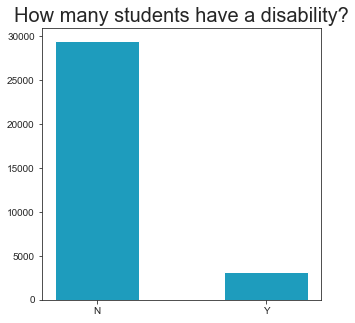

In [56]:
plot_cat_var(st_actives_with_vle.disability,'How many students have a disability?',size=(5,5))
st_actives_with_vle.disability.value_counts(normalize=True)

Almost 10% of students have a disability. Does this affect the final result?

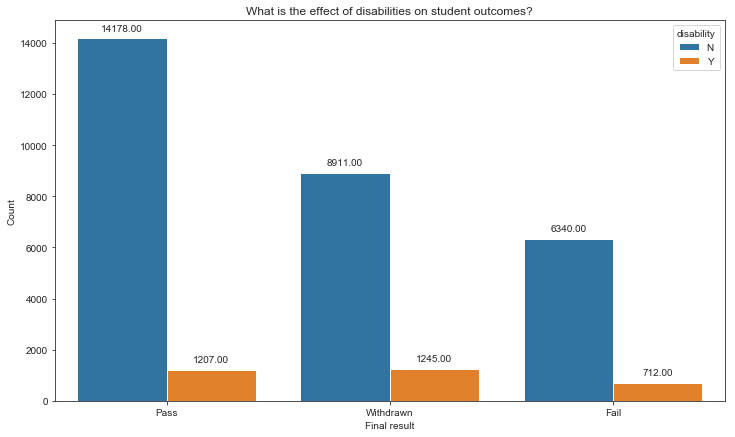

In [57]:
plt.figure(figsize=(12,7))
fig_4 = sns.countplot(x="final_result", hue="disability", data=st_actives_with_vle)
fig_4.set(xlabel='Final result', ylabel='Count',title='What is the effect of disabilities on student outcomes?');
for p in fig_4.patches:
    fig_4.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

There seems to be a small role that having a disability plays. The number of students with disabilities is slightly higher for students who withdrew, compared to disabled students who passed of failed. 

#### What is the role of gender?

M    0.548431
F    0.451569
Name: gender, dtype: float64

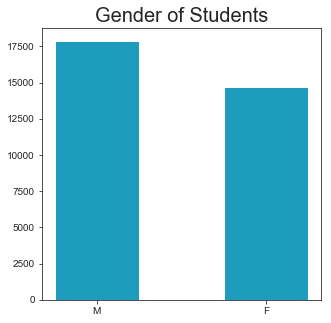

In [58]:
plot_cat_var(st_actives_with_vle.gender,'Gender of Students',size=(5,5))
st_actives_with_vle.gender.value_counts(normalize=True)

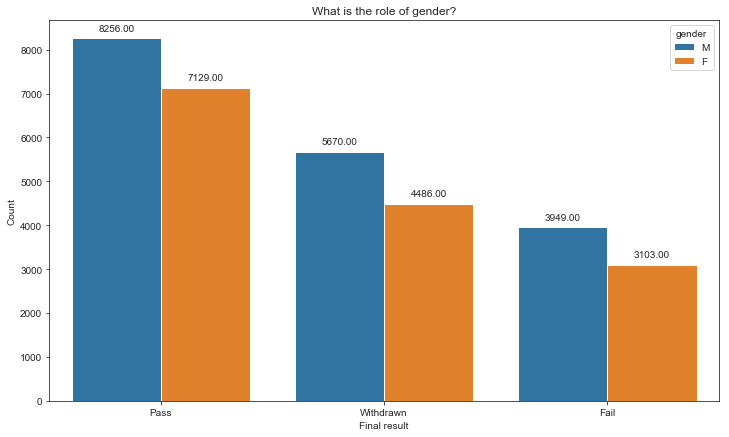

In [59]:
plt.figure(figsize=(12,7))
fig_5 = sns.countplot(x="final_result", hue="gender", data=st_actives_with_vle)
fig_5.set(xlabel='Final result', ylabel='Count',title='What is the role of gender?');
for p in fig_5.patches:
    fig_5.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Looking at the bar plot, it does not seem that gender influenced to outcome significantly.

#### What is the role of imd_band?

In [60]:
#turning imd into numerical variable for modelling
new_imd = {'90-100%':10, '20-30%':3, '30-40%':4, '50-60%':6, '80-90%':9, '70-80%':8,
       'Missing':5, '60-70%':7, '40-50%':5, '10-20':2, '0-10%':1}
st_actives_with_vle.imd_band = st_actives_with_vle.imd_band.map(new_imd)

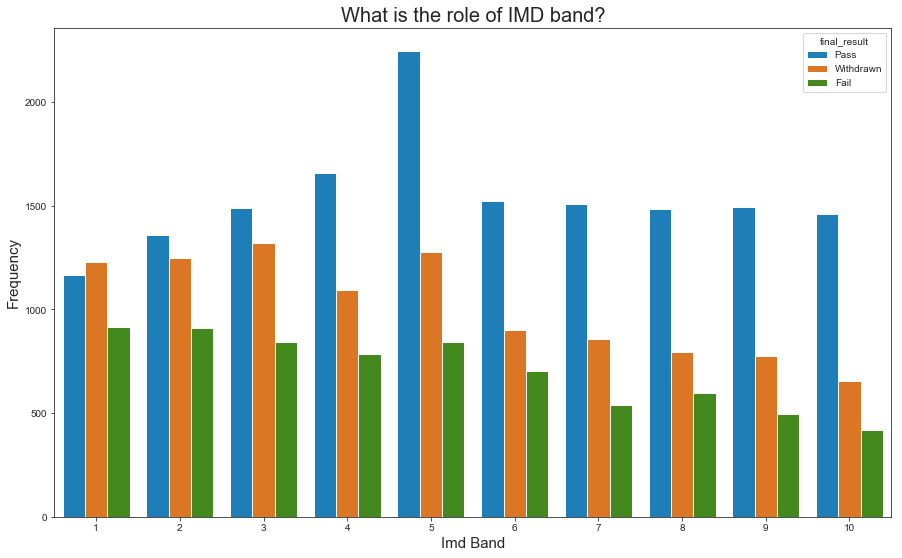

In [101]:
plt.figure(figsize=(15,9))
sns.countplot(x='imd_band',hue='final_result',data=st_actives_with_vle,palette=["#0485d1","#f97306", "#3f9b0b"])
plt.xlabel('Imd Band', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('What is the role of IMD band?',fontsize=20);

note: ignore the spike in band 5 students, as this category consumed the missing values

This visualisation is interesting, as it shows a relationship between the level of deprivation of the area where students live.

**The less deprived the area is, the more likely are the students to pass and less likely to withdraw or fail.**


# 3) Preparing Variables for Modelling

In [62]:
#renaming df
df = st_actives_with_vle.copy()
df.rename(columns={"final_result": "target"}, inplace=True)

#### Dropping unneccesary columns

In [63]:
to_drop = ['id_student']
df.drop(to_drop, axis=1,inplace=True)

#### Creating dummy variables

In [64]:
#selecting categorical columns
cat_cols = ['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'age_band','disability']

df = pd.get_dummies(data=df,columns = cat_cols, drop_first= True)

In [65]:
df.head()

,imd_band,num_of_prev_attempts,studied_credits,target,sum_of_clicks,mean_grade,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,...,region_Wales,region_West Midlands Region,region_Yorkshire Region,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_35-55,age_band_55<=,disability_Y
0,10,0,240,Pass,934.0,81.5,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,3,0,60,Pass,1435.0,69.0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,4,0,60,Withdrawn,281.0,77.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,6,0,60,Pass,2158.0,71.5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,0,60,Pass,1034.0,49.5,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [66]:
df.columns

Index(['imd_band', 'num_of_prev_attempts', 'studied_credits', 'target',
       'sum_of_clicks', 'mean_grade', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013J', 'code_presentation_2014B',
       'code_presentation_2014J', 'gender_M', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'age_band_35-55',
       'age_band_55<=', 'disability_Y'],
      dtype='object')

In [67]:
df.rename(columns={'age_band_55<=': "55+"}, inplace=True)

#### Splitting dataset - training, validation, testing set

In [68]:
from sklearn.model_selection import train_test_split

#I am going to cut away a random 5% of the dataset for final testing.

X_testing_set = df.drop('target',axis=1)
y_testing_set = df.target

#ts = 'TESTING SET'
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_testing_set, y_testing_set, test_size=0.05, random_state=123)

In [69]:
#putting my df back together
df = pd.concat([X_train_ts, y_train_ts],axis=1)

The following variables now contain the 5% testing set

df validation set:
   * y_test_ts - labels
   * X_test_ts - data

Creating the validation set (10% of data)

In [70]:
X = df.drop('target',axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### Tackling class imbalace

Pass         0.472532
Withdrawn    0.312050
Fail         0.215418
Name: target, dtype: float64

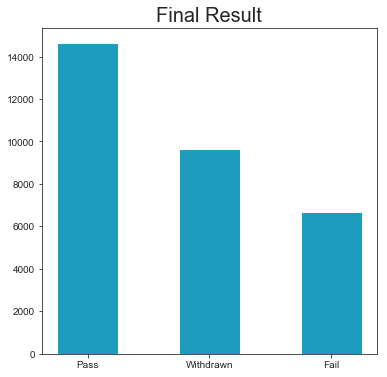

In [71]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

In [72]:
#to avoid data leakage when using SMOTE, I have split the data beforehand
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train);

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classe

In [73]:
#putting upsampled dataset back together
X_train = pd.DataFrame(X_train, columns=X_train_ts.columns)
y_train = pd.Series(y_train)

df = pd.concat([X_train,y_train],axis=1)

In [74]:
df.rename(columns={0: "target"}, inplace=True)

In [75]:
df.shape

(39393, 35)

In [76]:
df.head()

,imd_band,num_of_prev_attempts,studied_credits,sum_of_clicks,mean_grade,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,...,region_West Midlands Region,region_Yorkshire Region,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,age_band_35-55,55+,disability_Y,target
0,5.0,0.0,60.0,198.0,77.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Withdrawn
1,8.0,0.0,60.0,351.0,79.222222,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Fail
2,9.0,1.0,60.0,3093.0,79.333333,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Pass
3,9.0,0.0,355.0,1173.0,30.000000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Withdrawn
4,8.0,1.0,60.0,101.0,43.333333,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Fail


Fail         0.333333
Pass         0.333333
Withdrawn    0.333333
Name: target, dtype: float64

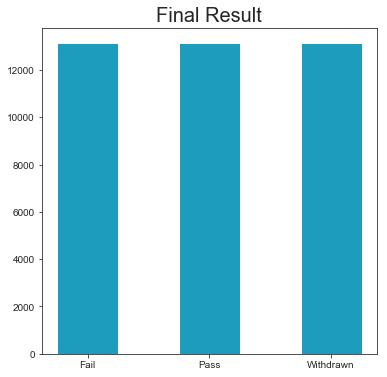

In [77]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

The result of this upsampling process is the equal representation of all three classes in the transformed dataset.

# 4) Modelling

In [78]:
#importing libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#import stats_for_classification as stats
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pylab as pl
import xgboost

#### PCA compression

In [88]:
#scaling data for PCA
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [94]:
pca_1 = PCA(n_components=32)

principalComponents = pca_1.fit_transform(scaled_X_train)

In [95]:
#looking at explained variance ratio of different number of components
print(np.sum(pca_1.explained_variance_ratio_))

0.9901574253241932


### Model 1 - baseline Random Forest without Grid-search

In [96]:
pipe_baseline = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=32)),
                  ('clf', RandomForestClassifier(random_state = 123))])

pipe_baseline.fit(X_train,y_train);

In [98]:
print('Training score: :'+str(round(pipe_baseline.score(X_train,y_train),3)))
print('Testing score: :'+str(round(pipe_baseline.score(X_test,y_test),3)))

Training score: :0.998
Testing score: :0.599


#### Model 1 summary:
* The testing accuracy of the baseline model is 60% and it is heavily overfitted

### Model 2 - Random Forest with Grid-search

In [99]:
#let's try this model with gridsearch
pipe_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=32)),
                  ('clf', RandomForestClassifier(random_state = 123,n_jobs=6))])

# Set grid search params
param_baseline_grid = [ 
  {'clf__n_estimators': [40,50,70],
   'clf__criterion': ['gini','entropy'], 
   'clf__max_depth': [10,15,20],  
   'clf__min_samples_leaf':[0.02,0.002],  
  }]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_baseline_grid,
            param_grid=param_baseline_grid,
            scoring='accuracy',
            cv=3, verbose=True, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

print('Best accuracy: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.2min finished


Best accuracy: 0.572

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 15, 'clf__min_samples_leaf': 0.002, 'clf__n_estimators': 40}


In [139]:
print('Training score: :'+str(round(gs_rf.score(X_train,y_train),3)))
print('Testing score: :'+str(round(gs_rf.score(X_test,y_test),3)))

Training score: :0.661
Testing score: :0.603


In [138]:
#predictions_grid_rf = gs_rf.predict(X_test)
#confusion_matrix(y_test,predictions_grid_rf)

#### Model 2 summary:
* The testing accuracy of this model is 60%, it is less overfitted than the baseline model

### Model 3 - XGBoost

In [74]:
#X_train = X_train.astype(int)
#X_test = X_test.astype(int)

In [105]:
#Instantiate XGBClassifier
xgb_cl_pipeline = XGBClassifier(nthread=8)


xgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=32)),
                 ('clf', xgb_cl_pipeline)])

# Set grid search params
param_grid_xgb = {
    'learning_rate': [0.1,0.01], #=eta, smaller number makes model more robust by shrinking weights on each step
    'max_depth': [20,40,80,120], #max depth of a three, controls over-fitting
    'min_child_weight': [20,40,60], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
   'subsample': [0.5], #the fraction of observations to be randomly samples for each tree.
    'n_estimators': [20,50,100],
}


grid_xgb = GridSearchCV(xgb_cl_pipeline, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train, y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(X_train)
test_preds = grid_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.01
max_depth: 80
min_child_weight: 40
n_estimators: 100
subsample: 0.5

Training Accuracy: 72.89%
Validation accuracy: 72.72%


In [159]:
model_3 = XGBClassifier(learning_rate= 0.1,nthread=8,max_depth=80,min_child_weight= 40,subsample=0.5,n_estimators=100)
model_3.fit(X_train, y_train)
model_3_preds = model_3.predict(X_train)
print(classification_report(y_train, model_3_preds))

              precision    recall  f1-score   support

        Fail       0.75      0.73      0.74     13131
        Pass       0.82      0.92      0.86     13131
   Withdrawn       0.81      0.74      0.77     13131

    accuracy                           0.79     39393
   macro avg       0.79      0.79      0.79     39393
weighted avg       0.79      0.79      0.79     39393



#### Model 3 summary:
* Using XGBoost has improved the accuracy score by 12%
* The model is now not iverfitted at all, which means it can be reliable for final testing

## Model 4 - Light GMB

In [81]:
#!pip install lightgbm
import lightgbm as lgb 

In [116]:
LGBM_pipeline = lgb.LGBMClassifier(nthread=1)

lgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=)),
                 ('clf', LGBM_pipeline)])

# Set grid search params
param_grid_lgb = {
    'learning_rate': [0.1,0.2], #=eta, smaller number makes model more robust by shrinking weights on each step
    'max_depth': [20,40,80], #max depth of a three, controls over-fitting
    'min_child_weight': [40], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
   'subsample': [0.6], #the fraction of observations to be randomly samples for each tree.
    'n_estimators': [50,100],
}


grid_lgb = GridSearchCV(LGBM_pipeline, param_grid_lgb, scoring='accuracy', cv=None, n_jobs=1)
grid_lgb.fit(X_train, y_train)

best_parameters = grid_lgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_lgb.predict(X_train)
test_preds = grid_lgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 40
min_child_weight: 40
n_estimators: 100
subsample: 0.6

Training Accuracy: 77.62%
Validation accuracy: 73.01%


Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 50
min_child_weight: 40
n_estimators: 50
subsample: 0.6

Training Accuracy: 76.68%
Validation accuracy: 74.46%


Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 40
min_child_weight: 20
n_estimators: 75
subsample: 0.6

Training Accuracy: 78.14%
Validation accuracy: 74.59%

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 40
min_child_weight: 20
n_estimators: 100
subsample: 0.6

Training Accuracy: 76.95%
Validation accuracy: 74.62%

In [82]:
model_4 = lgb.LGBMClassifier(learning_rate= 0.1,nthread=1,max_depth=40,min_child_weight= 20,subsample=0.6,n_estimators=100)
   
model_4.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=40,
               min_child_samples=20, min_child_weight=20, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, nthread=1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.6, subsample_for_bin=200000,
               subsample_freq=0)

The accuracy score of this model has remained similar to XGBoost, but this model has run faster.

#### Model 4 summary:
* The testing accuracy of this model 73% - this highest so far
* The model is not overfitted (training accuracy was 76%)

# 5) Examining final model and Conclusion 

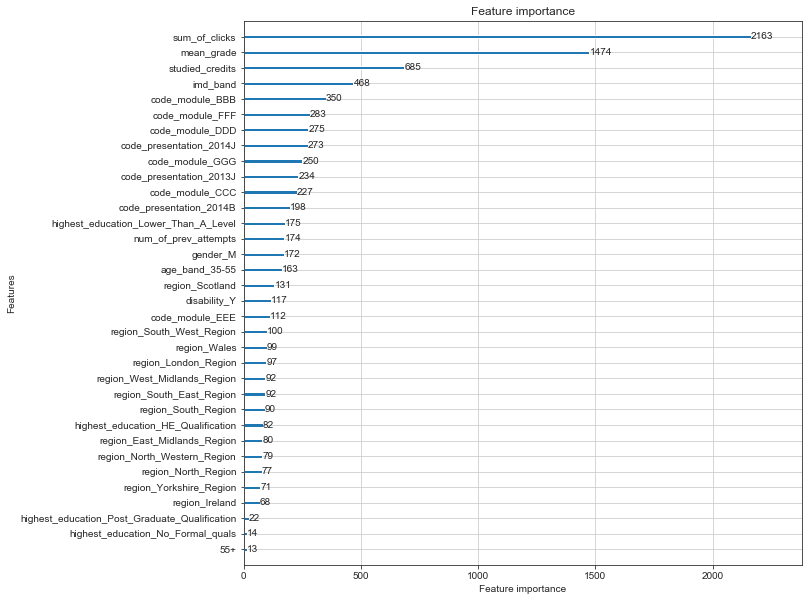

In [140]:
plt.rcParams["figure.figsize"] = (10,10)
lgb.plot_importance(model_4)

* The feature importance revealed the following crucial variables:


* **Number of clicks**
* **Average grade**
* **Number of studied credits**
* **IMD band**

In [156]:
model_4_preds = model_4.predict(X_train)

In [157]:
cf = confusion_matrix(y_train, model_4_preds)
cf

array([[ 8888,  1914,  2329],
       [  808, 11974,   349],
       [ 3021,  1182,  8928]], dtype=int64)

In [158]:
print(classification_report(y_train, model_4_preds))

              precision    recall  f1-score   support

        Fail       0.70      0.68      0.69     13131
        Pass       0.79      0.91      0.85     13131
   Withdrawn       0.77      0.68      0.72     13131

    accuracy                           0.76     39393
   macro avg       0.75      0.76      0.75     39393
weighted avg       0.75      0.76      0.75     39393



**The model is more likely to correctly identify students who pass than other categories.**

**The students who withdraw are more likely to be correctly identified than students who will fail.**


In [91]:
#final test on testing set
model_4_testing_preds = model_4.predict(X_test_ts)
print(classification_report(y_test_ts, model_4_testing_preds))
print(accuracy_score(y_test_ts, model_4_testing_preds))

              precision    recall  f1-score   support

        Fail       0.56      0.37      0.44       382
        Pass       0.79      0.92      0.85       754
   Withdrawn       0.71      0.73      0.72       494

    accuracy                           0.73      1630
   macro avg       0.69      0.67      0.67      1630
weighted avg       0.71      0.73      0.71      1630

0.7300613496932515


Benefits:
* This model is definitely better than random guessing and can correctly identify the result of 73% students.
* The model is not overfitted, so it is likely to deliver consistent results on new data

Drawbacks:
* The model struggles to correctly label students who will fail.

### Recommendations and Future Work:

These are some of the steps I would like to take if I were to continue working on this project:

* It would be benefitial to have more up-to-date data from the Open University Virtual Learning Environment, as the system now collects more varied data and the students are using it for more tasks. Such data would definitely bring about more accurate results and be a great material for more complex data analysis.
* Creating more variables that reflect the actions of students in VLE more specifically.
* It would also be interesting to implement unsupervised learning or clustering technique to discover more about the students and what makes them succeed.
* Further improvement of some variables and parameter settings could lead to a better-performing model.
* Additionaly, it might be worth considering merging the 'Withdrawn' and 'Fail' classes, as they would lead to the same real-world outcome (allocating more support to given student).